#**Intro to Machine Learning Final Project**
##Rain in Australia
#####Vincent Liok (vl1042) and Andrey Khegay (ak6585)

###**Problem description**
This project will analyze weather conditions in Australia, and try to predict whether or not it will rain on a given day, based on the previous day's weather conditions. This makes it a classification problem, so machine learning techniques like logistic regression and support vector machines (SVM) can be used for prediction. To prevent overfitting, different levels of regularization will be added to the ML model

In [ ]:
#Imports libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy.random as r

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn import linear_model
%matplotlib inline

In [ ]:
#Mounts Google Drive
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###**Dataset analysis**
The dataset used in this project contains around 10 years of daily weather measurements collected in various locations in Australia. These measurements include minimum and maximum temperature, amount of rainfall, wind speed, atmospheric pressure levels, etc.

In [ ]:
#Reads in data from CSV file, and removes null rows
weather_df = pd.read_csv("drive/MyDrive/weatherAUS.csv", header=0)
weather_df = weather_df.dropna()

In [ ]:
#Converts pandas dataframe into numpy array and shuffle
weather_data = np.array(weather_df)
weather_data = shuffle(weather_data, random_state=0)

In [ ]:
#Shows the dimensions of the data
print("Dimensions of dataset:", weather_data.shape)

Dimensions of dataset: (56420, 23)


In [ ]:
#Split the features and target, remove first two columns, use first 2000 rows
X = weather_data[:2000, 2:22]
y = weather_data[:2000, 22]


#Below is old code to balance the data
'''
test = weather_data[-1000:]
training = np.zeros((1000, 23), dtype=object)

count = 0
for i in range(len(weather_data)):
  if (weather_data[i][-1] == "Yes"):
    training[count] = weather_data[i]
    count += 1
    if (count >= 500):
      break

for i in range(len(weather_data)):
  if (weather_data[i][-1] == "No"):
    training[count] = weather_data[i]
    count += 1
    if (count >= 1000):
      break

total = np.vstack((training, test))
total = total[:, 2:]
total = np.delete(total, 8, 1)
total = np.delete(total, 7, 1)
total = np.delete(total, 5, 1)

for i in range(len(total)):
  if (total[i][-1] == "Yes"):
    total[i][-1] = 1.
  if (total[i][-2] == "Yes"):
    total[i][-2] = 1.
  if (total[i][-1] == "No"):
    total[i][-1] = 0.
  if (total[i][-2] == "No"):
    total[i][-2] = 0.

X = total[:, :17]
y = total[:, 17].reshape((2000,1)).astype(float)

X_scale = StandardScaler()
X = X_scale.fit_transform(X)

total = np.hstack((X,y))

training = total[:1000]
test = total[1000:]

training = shuffle(training, random_state=1)

X_train = training[:, :17]
y_train = training[:, 17].reshape((1000,1)).astype(float)

X_test = test[:, :17]
y_test = test[:, 17].reshape((1000,1)).astype(float)
'''

#Remove wind direction columns
X = np.delete(X, 8, 1)
X = np.delete(X, 7, 1)
X = np.delete(X, 5, 1)

#Change "Yes" and "No" to 1 and 0
for i in range(len(X)):
  if (X[i][-1] == "Yes"):
    X[i][-1] = 1.
  else:
    X[i][-1] = 0.

for i in range(len(y)):
  if (y[i] == "Yes"):
    y[i] = 1.
  else:
    y[i] = 0.

#Scale the data
X_scale = StandardScaler()
X = X_scale.fit_transform(X)

#Reshape y
y = y.reshape((2000,1)).astype(float)




In [ ]:
#Splitting the dataset into training and test data.
X_train = X[:1000]
y_train = y[:1000]
X_test = X[1000:]
y_test = y[1000:]

###**Neural Network**

In [ ]:
#Sigmoid functions
def f(z):
    #z = z.astype(float)
    return 1 / (1 + np.exp(-z))

def f_deriv(z):
    return f(z) * (1 - f(z))

#Setup weights
def setup_and_init_weights(nn_structure):
    W = {} #creating a dictionary i.e. a set of key: value pairs
    b = {}
    for l in range(1, len(nn_structure)):
        W[l] = r.random_sample((nn_structure[l], nn_structure[l-1])) #Return “continuous uniform” random floats in the half-open interval [0.0, 1.0). 
        b[l] = r.random_sample((nn_structure[l],))
    return W, b

def init_tri_values(nn_structure):
    tri_W = {}
    tri_b = {}
    for l in range(1, len(nn_structure)):
        tri_W[l] = np.zeros((nn_structure[l], nn_structure[l-1]))
        tri_b[l] = np.zeros((nn_structure[l],))
    return tri_W, tri_b

#Feed forward
def feed_forward(x, W, b):
    a = {1: x} # create a dictionary for holding the a values for all levels
    z = { } # create a dictionary for holding the z values for all the layers
    for l in range(1, len(W) + 1): # for each layer
        node_in = a[l]
        z[l+1] = W[l].dot(node_in) + b[l]  # z^(l+1) = W^(l)*a^(l) + b^(l)
        a[l+1] = f(z[l+1]) # a^(l+1) = f(z^(l+1))
    return a, z

#Calculate delta
def calculate_out_layer_delta(y, a_out, z_out):
    # delta^(nl) = -(y_i - a_i^(nl)) * f'(z_i^(nl))
    return -(y-a_out) * f_deriv(z_out) 

def calculate_hidden_delta(delta_plus_1, w_l, z_l):
    # delta^(l) = (transpose(W^(l)) * delta^(l+1)) * f'(z^(l))
    return np.dot(np.transpose(w_l), delta_plus_1) * f_deriv(z_l)

#Back propagation algorithm
def train_nn(nn_structure, X, y, iter_num=3000, alpha=0.5, lamb=0.001):
    W, b = setup_and_init_weights(nn_structure)
    cnt = 0
    N = len(y)
    avg_cost_func = []
    print('Starting gradient descent for {} iterations'.format(iter_num))
    while cnt < iter_num:
        #print(cnt)
        #if cnt%1000 == 0:
        #    print('Iteration {} of {}'.format(cnt, iter_num))
        tri_W, tri_b = init_tri_values(nn_structure)
        avg_cost = 0
        for i in range(N):
            delta = {}
            # perform the feed forward pass and return the stored a and z values, to be used in the
            # gradient descent step
            a, z = feed_forward(X[i, :], W, b)
            # loop from nl-1 to 1 backpropagating the errors
            for l in range(len(nn_structure), 0, -1):
                if l == len(nn_structure):
                    delta[l] = calculate_out_layer_delta(y[i,:], a[l], z[l])
                    avg_cost += np.linalg.norm((y[i,:]-a[l]))
                else:
                    if l > 1:
                        delta[l] = calculate_hidden_delta(delta[l+1], W[l], z[l])
                    # triW^(l) = triW^(l) + delta^(l+1) * transpose(a^(l))
                    tri_W[l] += np.dot(delta[l+1][:,np.newaxis], np.transpose(a[l][:,np.newaxis]))# np.newaxis increase the number of dimensions
                    # trib^(l) = trib^(l) + delta^(l+1)
                    tri_b[l] += delta[l+1]
        # perform the gradient descent step for the weights in each layer
        for l in range(len(nn_structure) - 1, 0, -1):
            W[l] += -alpha * (1.0/N * tri_W[l] + lamb * W[l])
            b[l] += -alpha * (1.0/N * tri_b[l])
        # complete the average cost calculation
        avg_cost = 1.0/N * avg_cost
        avg_cost_func.append(avg_cost)
        cnt += 1
    return W, b, avg_cost_func


def predict_y(W, b, X, n_layers):
    N = X.shape[0]
    y = np.zeros((N,))
    for i in range(N):
        a, z = feed_forward(X[i, :], W, b)
        if (a[n_layers] > 0.5):
            y[i] = 1.0
        else:
            y[i] = 0.0
    return y

nn_structure = [17, 10, 1]
    
# train the NN
#W, b, avg_cost_func = train_nn(nn_structure, X_train, y_train)

In [ ]:
# plot the avg_cost_func
#plt.plot(avg_cost_func)
#plt.ylabel('Average J')
#plt.xlabel('Iteration number')
#plt.show()

In [ ]:
# get the prediction accuracy and print
#y_pred = predict_y(W, b, X_train, 3)
y_test_temp = y_test.reshape(1000).astype(float)
y_train_temp = y_train.reshape(1000).astype(float)
#print('Prediction accuracy is {}%'.format(accuracy_score(y_test_temp, y_pred) * 100))

Starting gradient descent for 1000 iterations


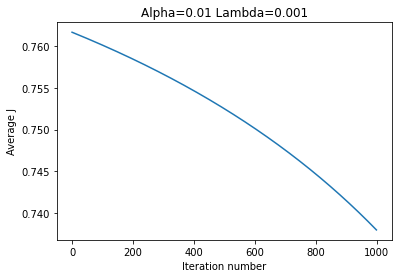

Train Accuracy is 20.5% for 0.01, 0.001
Test Accuracy is 23.1% for 0.01, 0.001
Starting gradient descent for 1000 iterations


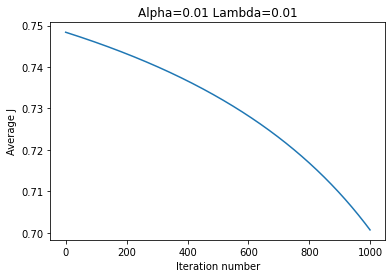

Train Accuracy is 20.5% for 0.01, 0.01
Test Accuracy is 23.1% for 0.01, 0.01
Starting gradient descent for 1000 iterations


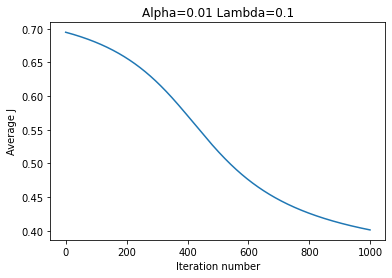

Train Accuracy is 79.5% for 0.01, 0.1
Test Accuracy is 76.9% for 0.01, 0.1
Starting gradient descent for 1000 iterations


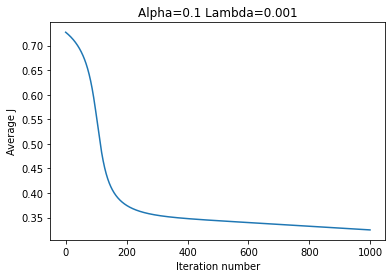

Train Accuracy is 79.5% for 0.1, 0.001
Test Accuracy is 76.9% for 0.1, 0.001
Starting gradient descent for 1000 iterations


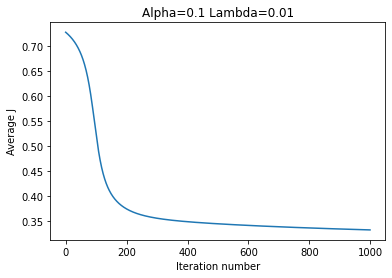

Train Accuracy is 79.5% for 0.1, 0.01
Test Accuracy is 76.9% for 0.1, 0.01
Starting gradient descent for 1000 iterations


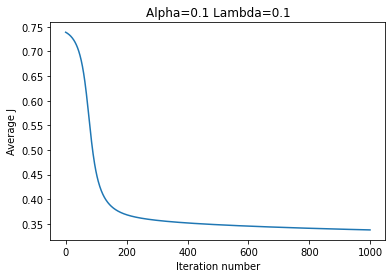

Train Accuracy is 79.5% for 0.1, 0.1
Test Accuracy is 76.9% for 0.1, 0.1
Starting gradient descent for 1000 iterations


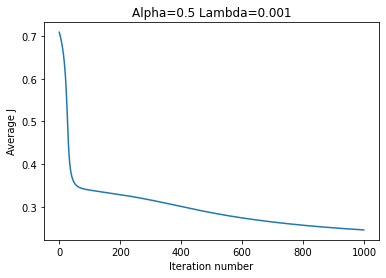

Train Accuracy is 84.39999999999999% for 0.5, 0.001
Test Accuracy is 81.69999999999999% for 0.5, 0.001
Starting gradient descent for 1000 iterations


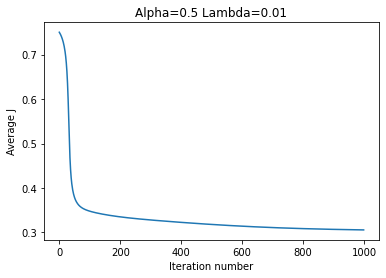

Train Accuracy is 79.7% for 0.5, 0.01
Test Accuracy is 77.0% for 0.5, 0.01
Starting gradient descent for 1000 iterations


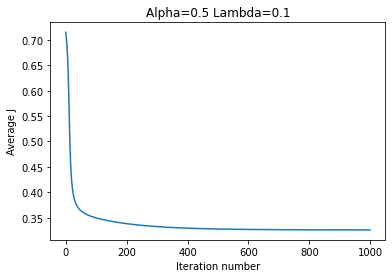

Train Accuracy is 79.5% for 0.5, 0.1
Test Accuracy is 76.9% for 0.5, 0.1
[[2.05e+01 2.31e+01 1.00e-02 1.00e-03]
 [2.05e+01 2.31e+01 1.00e-02 1.00e-02]
 [7.95e+01 7.69e+01 1.00e-02 1.00e-01]
 [7.95e+01 7.69e+01 1.00e-01 1.00e-03]
 [7.95e+01 7.69e+01 1.00e-01 1.00e-02]
 [7.95e+01 7.69e+01 1.00e-01 1.00e-01]
 [8.44e+01 8.17e+01 5.00e-01 1.00e-03]
 [7.97e+01 7.70e+01 5.00e-01 1.00e-02]
 [7.95e+01 7.69e+01 5.00e-01 1.00e-01]] [8.44e+01 8.17e+01 5.00e-01 1.00e-03]


In [ ]:
alpha = [0.01, 0.1, 0.5]
lamb = [0.001, 0.01, 0.1]



results = np.zeros((len(alpha)*len(lamb), 4))
cnt = 0
for al in alpha:
  for l in lamb:
    W, b, avg_cost = train_nn(nn_structure, X_train, y_train, iter_num=1000, alpha=al, lamb=l)
    # plot the avg_cost_func
    plt.plot(avg_cost)
    plt.ylabel('Average J')
    plt.xlabel('Iteration number')
    plt.title("Alpha={} Lambda={}".format(al, l))
    plt.show()
    y_pred = predict_y(W, b, X_train, 3)
    train_accuracy = accuracy_score(y_train_temp, y_pred) * 100
    print("Train Accuracy is {}% for {}, {}".format(train_accuracy, al, l))
    y_pred = predict_y(W, b, X_test, 3)
    test_accuracy = accuracy_score(y_test_temp, y_pred) * 100
    print("Test Accuracy is {}% for {}, {}".format(test_accuracy, al, l))
    # store the data
    results[cnt, 0] = train_accuracy
    results[cnt, 1] = test_accuracy
    results[cnt, 2] = al
    results[cnt, 3] = l
    cnt += 1
# get the index of the best accuracy
best_idx = np.argmax(results[:, 0])
print(results, results[best_idx, :])

###**Logistic Regression**

In [ ]:
#Reshapes labels into 1D array
y_train = y_train.reshape((1000,))
y_test = y_test.reshape((1000,))

####Lasso regularization

In [ ]:
#Declares lists to store accuracy values
training_acc_lasso = []
test_acc_lasso = []
c_lasso = []

In [ ]:
#Logistic regression with lasso regularization
def logreg_model_lasso(c, X_train, y_train, X_test, y_test):
    logreg = linear_model.LogisticRegression(penalty="l1", C=c, solver="saga")
    logreg.fit(X_train, y_train)
    yhat_train = logreg.predict(X_train)
    
    # Adding training accuracy to training_acc_lasso
    training_acc = logreg.score(X_train, y_train)
    training_acc_lasso.append(training_acc)
    print("Accuracy on training data = %f" % training_acc)
    
    yhat_test = logreg.predict(X_test)
    
    # Adding testing accuracy to test_acc_lasso
    test_acc = logreg.score(X_test, y_test)
    test_acc_lasso.append(test_acc)
    print("Accuracy on test data = %f\n" % test_acc)
  
    # Appending value of c for graphing purposes
    c_lasso.append(c)

In [ ]:
#Runs logistic regression with different levels of lasso regularization
c_vals = [0.0001, 0.001, 0.01, 0.1, 1, 10]

for c in c_vals:
  print("c = {}".format(c))
  logreg_model_lasso(c, X_train, y_train, X_test, y_test)

c = 0.0001
Accuracy on training data = 0.795000
Accuracy on test data = 0.769000

c = 0.001
Accuracy on training data = 0.795000
Accuracy on test data = 0.769000

c = 0.01
Accuracy on training data = 0.796000
Accuracy on test data = 0.769000

c = 0.1
Accuracy on training data = 0.855000
Accuracy on test data = 0.844000

c = 1
Accuracy on training data = 0.864000
Accuracy on test data = 0.846000

c = 10
Accuracy on training data = 0.862000
Accuracy on test data = 0.850000



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


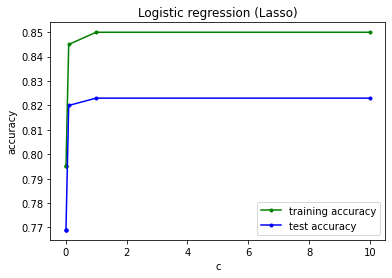

In [ ]:
#Plots the accuracy data
plt.plot(c_lasso, training_acc_lasso, ".-", color="green")
plt.plot(c_lasso, test_acc_lasso, ".-", color="blue")
plt.title("Logistic regression (Lasso)")
plt.xlabel("c")
plt.ylabel("accuracy")
plt.legend(["training accuracy", "test accuracy"])

####Ridge regularization

In [ ]:
#Initializes lists to store accuracy values
training_acc_ridge = []
test_acc_ridge = []
c_ridge = []

In [ ]:
#Logistic regression with ridge regularization
def logreg_model_ridge(c, X_train, y_train, X_test, y_test):
    logreg = linear_model.LogisticRegression(C=c) #penalty is l2 (ridge) by default
    logreg.fit(X_train, y_train)
    yhat_train = logreg.predict(X_train)
    
    # Adding training accuracy to training_acc_lasso
    training_acc = logreg.score(X_train, y_train)
    training_acc_ridge.append(training_acc)
    print("Accuracy on training data = %f" % training_acc)
    
    yhat_test = logreg.predict(X_test)
    
    # Adding testing accuracy to test_acc_lasso
    test_acc = logreg.score(X_test, y_test)
    test_acc_ridge.append(test_acc)
    print("Accuracy on test data = %f\n" % test_acc)
  
    # Appending value of c for graphing purposes
    c_ridge.append(c)

In [ ]:
#Runs logistic regression with different levels of ridge regularization
c_vals = [0.0001, 0.001, 0.01, 0.1, 1, 10]

for c in c_vals:
  print("c = {}".format(c))
  logreg_model_ridge(c, X_train, y_train, X_test, y_test)

c = 0.0001
Accuracy on training data = 0.795000
Accuracy on test data = 0.769000

c = 0.001
Accuracy on training data = 0.799000
Accuracy on test data = 0.773000

c = 0.01
Accuracy on training data = 0.850000
Accuracy on test data = 0.825000

c = 0.1
Accuracy on training data = 0.860000
Accuracy on test data = 0.841000

c = 1
Accuracy on training data = 0.861000
Accuracy on test data = 0.848000

c = 10
Accuracy on training data = 0.863000
Accuracy on test data = 0.845000



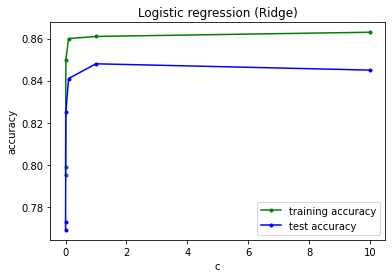

In [ ]:
#Plots the accuracy data
plt.plot(c_ridge, training_acc_ridge, ".-", color="green")
plt.plot(c_ridge, test_acc_ridge, ".-", color="blue")
plt.title("Logistic regression (Ridge)")
plt.xlabel("c")
plt.ylabel("accuracy")
plt.legend(["training accuracy", "test accuracy"])

####Polynomial Transformation

In [ ]:
#Transforms features
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2)

X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.fit_transform(X_test)
print(X_train.shape)
print(X_train_poly.shape)

(1000, 17)
(1000, 171)


c = 0.0001
Accuracy on training data = 0.795000
Accuracy on test data = 0.769000

c = 0.001
Accuracy on training data = 0.795000
Accuracy on test data = 0.769000

c = 0.01


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Accuracy on training data = 0.795000
Accuracy on test data = 0.769000

c = 0.1


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Accuracy on training data = 0.845000
Accuracy on test data = 0.819000

c = 1


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Accuracy on training data = 0.850000
Accuracy on test data = 0.823000

c = 10
Accuracy on training data = 0.850000
Accuracy on test data = 0.823000



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


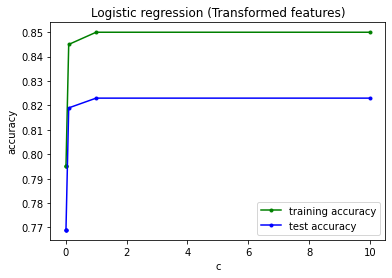

In [ ]:
#Lasso regularization
training_acc_lasso = []
test_acc_lasso = []
c_lasso = []

#Runs logistic regression with transformed features
for c in c_vals:
  print("c = {}".format(c))
  logreg_model_lasso(c, X_train_poly, y_train, X_test_poly, y_test)

#Plots the accuracy data
plt.plot(c_lasso, training_acc_lasso, ".-", color="green")
plt.plot(c_lasso, test_acc_lasso, ".-", color="blue")
plt.title("Logistic regression (Transformed features)")
plt.xlabel("c")
plt.ylabel("accuracy")
plt.legend(["training accuracy", "test accuracy"])

###**SVM**

####Linear Kernel

In [ ]:
#Initializes lists to store accuracy values
training_acc_svm_linear = []
test_acc_svm_linear = []
c_svm_linear = []

In [ ]:
#Linear SVM
from sklearn import svm

def svm_linear(c):
    svc_linear = svm.SVC(probability=False, kernel="linear", C=c)
    
    svc_linear.fit(X_train, y_train) 
    yhat_svc_linear_train = svc_linear.predict(X_train)
    training_acc = svc_linear.score(X_train, y_train)
    
    # Adding testing accuracy to acc_train_svm
    training_acc_svm_linear.append(training_acc)
    print('Train Accuracy = {0:f}'.format(training_acc))
    
    yhat_svc_linear_test = svc_linear.predict(X_test)
    test_acc = svc_linear.score(X_test, y_test)
    
    # Adding testing accuracy to acc_test_svm
    test_acc_svm_linear.append(test_acc)
    print('Test Accuracy = {0:f}\n'.format(test_acc))
    
    # Appending value of c for graphing purposes
    c_svm_linear.append(c)

In [ ]:
#Runs Linear SVM with different levels of regularization
c_vals = [0.0001, 0.001, 0.01, 0.1, 1, 10]

for c in c_vals:
  print("c = {}".format(c))
  svm_linear(c)

c = 0.0001
Train Accuracy = 0.795000
Test Accuracy = 0.769000

c = 0.001
Train Accuracy = 0.796000
Test Accuracy = 0.769000

c = 0.01
Train Accuracy = 0.856000
Test Accuracy = 0.832000

c = 0.1
Train Accuracy = 0.861000
Test Accuracy = 0.839000

c = 1
Train Accuracy = 0.866000
Test Accuracy = 0.842000

c = 10
Train Accuracy = 0.868000
Test Accuracy = 0.845000



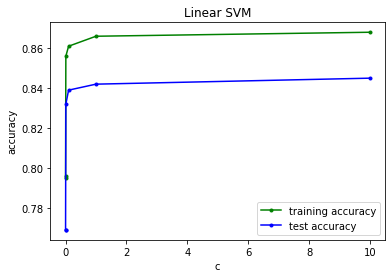

In [ ]:
#Plots the accuracy data
plt.plot(c_svm_linear, training_acc_svm_linear, ".-", color="green")
plt.plot(c_svm_linear, test_acc_svm_linear, ".-", color="blue")
plt.title("Linear SVM")
plt.xlabel("c")
plt.ylabel("accuracy")
plt.legend(["training accuracy", "test accuracy"])

####RBF Kernel

In [ ]:
#Initializes lists to store accuracy values
training_acc_svm_rbf = []
test_acc_svm_rbf = []
c_svm_rbf = []

In [ ]:
#RBF SVM
def svm_rbf(c):
    svc_rbf = svm.SVC(probability=False, kernel="rbf", C=c)
    
    svc_rbf.fit(X_train, y_train) 
    yhat_svc_rbf_train = svc_rbf.predict(X_train)
    training_acc = svc_rbf.score(X_train, y_train)
    
    # Adding testing accuracy to acc_train_svm
    training_acc_svm_rbf.append(training_acc)
    print('Train Accuracy = {0:f}'.format(training_acc))
    
    yhat_svc_rbf_test = svc_rbf.predict(X_test)
    test_acc = svc_rbf.score(X_test, y_test)
    
    # Adding testing accuracy to acc_test_svm
    test_acc_svm_rbf.append(test_acc)
    print('Test Accuracy = {0:f}\n'.format(test_acc))
    
    # Appending value of c for graphing purposes
    c_svm_rbf.append(c)

In [ ]:
#Runs RBF SVM with different levels of regularization
c_vals = [0.0001, 0.001, 0.01, 0.1, 1, 10]

for c in c_vals:
  print("c = {}".format(c))
  svm_rbf(c)

c = 0.0001
Train Accuracy = 0.795000
Test Accuracy = 0.769000

c = 0.001
Train Accuracy = 0.795000
Test Accuracy = 0.769000

c = 0.01
Train Accuracy = 0.795000
Test Accuracy = 0.769000

c = 0.1
Train Accuracy = 0.816000
Test Accuracy = 0.785000

c = 1
Train Accuracy = 0.880000
Test Accuracy = 0.836000

c = 10
Train Accuracy = 0.956000
Test Accuracy = 0.833000



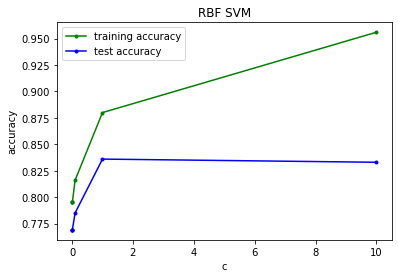

In [ ]:
#Plots the accuracy data
plt.plot(c_svm_rbf, training_acc_svm_rbf, ".-", color="green")
plt.plot(c_svm_rbf, test_acc_svm_rbf, ".-", color="blue")
plt.title("RBF SVM")
plt.xlabel("c")
plt.ylabel("accuracy")
plt.legend(["training accuracy", "test accuracy"])

####Polynomial Kernel

In [ ]:
#Initializes lists to store accuracy values
training_acc_svm_poly = []
test_acc_svm_poly = []
c_svm_poly = []

In [ ]:
#Polynomial SVM
def svm_polynomial(c):
    svc_polynomial = svm.SVC(probability=False, kernel="poly", C=c)
  
    svc_polynomial.fit(X_train, y_train)
    # TODO - Find the prediction and accuracy on the training set - 5 points
    yhat_svc_poly_train = svc_polynomial.predict(X_train)
    training_acc = svc_polynomial.score(X_train, y_train)
    
    # Adding testing accuracy to acc_train_svm
    training_acc_svm_poly.append(training_acc)
    print('Train Accuracy = {0:f}'.format(training_acc))
    
    # TODO - Find the prediction and accuracy on the test set - 5 points
    yhat_svc_poly_test = svc_polynomial.predict(X_test)
    test_acc = svc_polynomial.score(X_test, y_test)
    
    # Adding testing accuracy to acc_test_svm
    test_acc_svm_poly.append(test_acc)
    print('Test Accuracy = {0:f}\n'.format(test_acc))
    
    # Appending value of c for graphing purposes
    c_svm_poly.append(c)

In [ ]:
#Runs Polynomial SVM with different levels of regularization
c_vals = [0.0001, 0.001, 0.01, 0.1, 1, 10]

for c in c_vals:
  print("c = {}".format(c))
  svm_polynomial(c)

c = 0.0001
Train Accuracy = 0.796000
Test Accuracy = 0.769000

c = 0.001
Train Accuracy = 0.796000
Test Accuracy = 0.769000

c = 0.01
Train Accuracy = 0.802000
Test Accuracy = 0.774000

c = 0.1
Train Accuracy = 0.846000
Test Accuracy = 0.817000

c = 1
Train Accuracy = 0.884000
Test Accuracy = 0.832000

c = 10
Train Accuracy = 0.935000
Test Accuracy = 0.827000



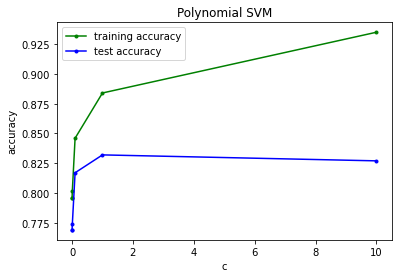

In [ ]:
#Plots the accuracy data
plt.plot(c_svm_poly, training_acc_svm_poly, ".-", color="green")
plt.plot(c_svm_poly, test_acc_svm_poly, ".-", color="blue")
plt.title("Polynomial SVM")
plt.xlabel("c")
plt.ylabel("accuracy")
plt.legend(["training accuracy", "test accuracy"])